### Install and Import Libraries

In [2]:
# !pip install nibabel #Library to work with Nifti Images

In [35]:
# !pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)


In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import metrics
import nibabel as nib
import pandas as pd

### Data Loading

In [4]:
def slice_show(image, slice_no):
    """ 
    A function to visualize 2D slices from 3D volume Image.
    Inputs 
      image: 3D Nifti Image
      slice_no: Which Slice you want to visualize
    Outputs
      plot the images
    
    """
    plt.figure()
    plt.axis('off')
    plt.imshow(image[:,:,slice_no].T, cmap='gray')

In [5]:
# Id's of the given images
data_list = ['1000', '1001', '1002', '1006', '1007', '1008',
            '1009', '1010', '1011', '1012', '1013', '1014',
            '1015', '1017', '1036'] 

# A list for holding normalized root mean square errors per fixed image
rmse_list = [] 

#Important directories for OS Operation
elastix_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\elastix'
input_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-images\\'
output_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\outputs\\'
parameter_affine_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\Par009Affine.txt'
parameter_elastic_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\Par009Elastic.txt'

###### To be able to run this code you have to rearrange your output folder like this way

<div>
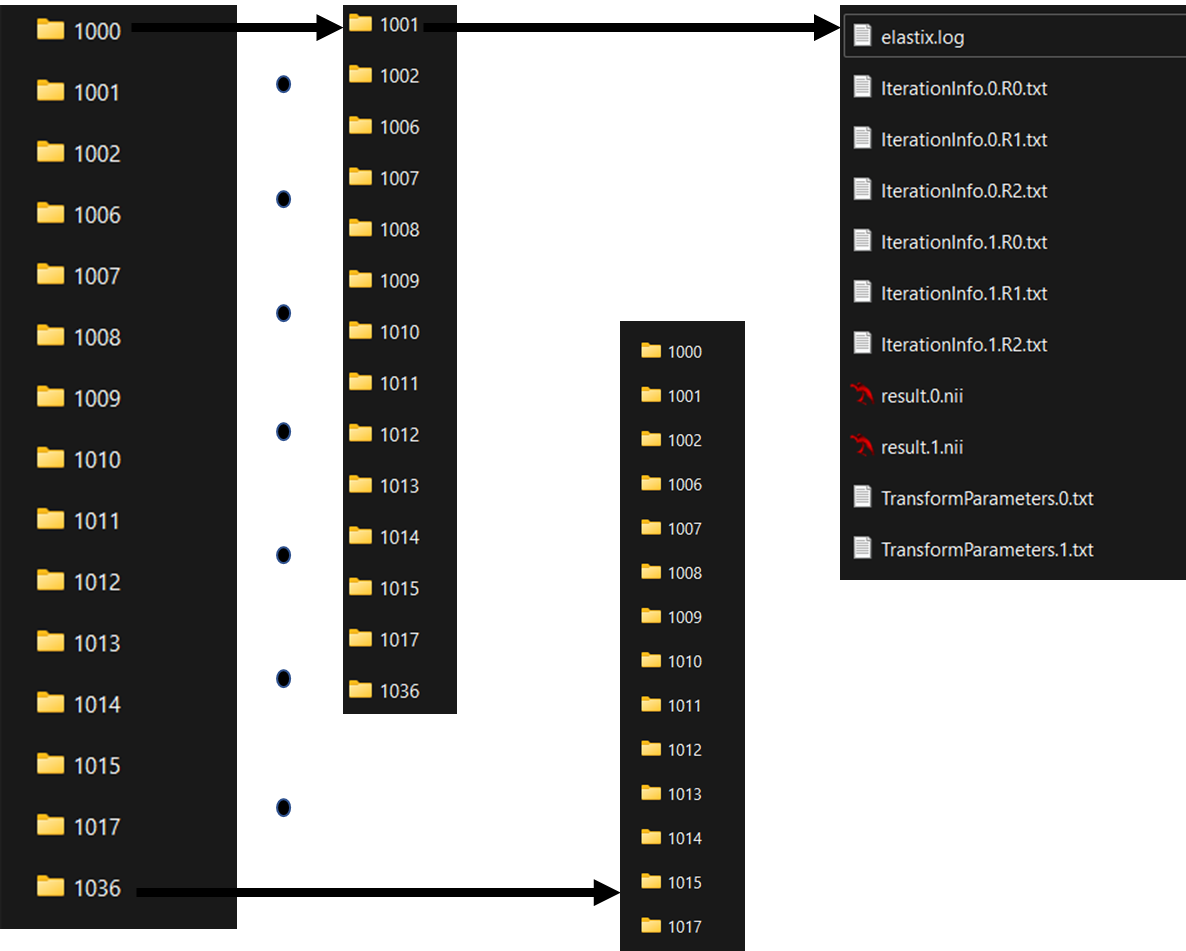
</div>

### Image Registration

In [6]:
# Block for generating Image Registration for each fixed image
for fixed in data_list:
    temp_output_directory = output_directory + fixed + '\\'
    # Location for the fixed image
    current_fixed_directory = input_directory + fixed + '.nii'
    fixed_img_data = nib.load(current_fixed_directory)
    # fixed image 
    current_fixed_img = fixed_img_data.get_fdata()
    # Initialization of normalized root mean squared error for each iteration in the loop
    rmse_sum = 0 
    for moving in data_list:
        if(moving != fixed):
            # Location to the place where output results will be stored
            current_output_directory = temp_output_directory + moving + '\\'
            # Location for the moving image
            current_moving_directory = input_directory + moving + '.nii'
            
            # Generating Image Registration for all the fixed images (Run Once)
            # os.system("cd /d F: && cd "+elastix_directory+"&& elastix -f "+current_fixed_directory+" -m "+current_moving_directory+" -out "+current_output_directory+" -p "+parameter_affine_directory+" -p "+parameter_elastic_directory+"")
            
            # Location of the final registered image after affine and elastic trasformation 
            current_result_directory = current_output_directory + 'result.1.nii'
            
            # Final Registered image
            result_img_data = nib.load(current_result_directory)
            current_result_img = result_img_data.get_fdata()
            
            # Computing and storing the error metric
            current_error = metrics.normalized_root_mse(current_fixed_img, current_result_img)
            rmse_sum = rmse_sum + current_error
    rmse_avg = rmse_sum/14
    rmse_list.append((fixed,rmse_avg))

In [7]:
# Finding the fixed image with lowest rmse
df = pd.DataFrame (rmse_list, columns = ['fixed_image', 'RMSE'])
print (df)

   fixed_image      RMSE
0         1000  0.350595
1         1001  0.461044
2         1002  0.499629
3         1006  0.346033
4         1007  0.384170
5         1008  0.329731
6         1009  0.377230
7         1010  0.380148
8         1011  0.355938
9         1012  0.488612
10        1013  0.354709
11        1014  0.460180
12        1015  0.430695
13        1017  0.439301
14        1036  0.627759


### Label Propagation

In [8]:
# Label transformation for Probabilistic Atlas
best_fixed_img_num = '1008'

# Locations for the ground truths
labels_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-labels\\'
temp_labels_output_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\outputs\\'

# location of the place where the transformed label will be stored
labels_output_directory = temp_labels_output_directory + best_fixed_img_num + '\\'
for data in data_list:
    if data != best_fixed_img_num:
        current_labels_directory = labels_directory + data + '_3C.nii'
        current_labels_output_directory = labels_output_directory + data + '\\'
        # The final transformation matrix generated after Image Registration
        transformix_param_directory = current_labels_output_directory + 'TransformParameters.1.txt'
        # Transform the labels too using the matrix generated after image registration (Run Once)
        # os.system("cd /d F: && cd "+elastix_directory+"&& transformix -in "+current_labels_directory+" -out "+current_labels_output_directory+" -tp "+transformix_param_directory+"")
        

### Intensity Atlas

In [9]:
#Intensity Atlas

# Extracting the best fixed image with lowest rmse
best_fixed_img_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-images\\'+best_fixed_img_num+'.nii'
best_fixed_img_data = nib.load(best_fixed_img_directory)
best_fixed_img = best_fixed_img_data.get_fdata()

# Initializing Intensity Atlas image with the same shape of the fixed image
intensity_atlas_img = np.zeros((best_fixed_img.shape))
# Location to store the results
intensity_output_directory = labels_output_directory
for data in data_list:
    if data != best_fixed_img_num:
        # Traversing each output image registration result and adding up to the intensity atlas
        current_intensity_output_directory = intensity_output_directory + data + '\\result.1.nii'
        current_intensity_atlas_data = nib.load(current_intensity_output_directory)
        current_intensity_atlas_img = current_intensity_atlas_data.get_fdata()
        intensity_atlas_img = intensity_atlas_img + current_intensity_atlas_img
# getting the average intensity dividing by the total number of images
intensity_atlas_img = intensity_atlas_img/14

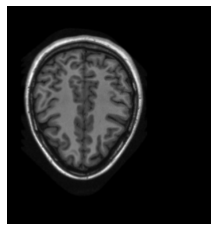

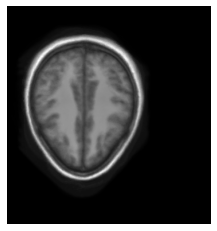

In [10]:
# Visualize the intensity atlas result per one slice
slice_no = 144
slice_show(best_fixed_img, slice_no)
slice_show(intensity_atlas_img, slice_no)

In [11]:
# Saving the results for intensity atlas
intensity_atlas_nifti = nib.Nifti1Image(intensity_atlas_img, best_fixed_img_data.affine, best_fixed_img_data.header)
nib.save(intensity_atlas_nifti, output_directory + '/intensity_atlas_nifti.nii')

### Probabilistic Atlas

In [12]:
# Probabilistic Atlas

# Initialization of three probabilistic atlas image with the same shape of the fixed image
sum_csf = np.zeros((best_fixed_img.shape))
sum_gm = np.zeros((best_fixed_img.shape))
sum_wm = np.zeros((best_fixed_img.shape))
for data in data_list:
    if data != best_fixed_img_num:
        # Traversing along the transformed labels for each case of the moving images
        current_label_output_directory = intensity_output_directory + data + '\\result.nii'
        current_label_data = nib.load(current_label_output_directory)
        # Getting the labeled image generated after label propagation step
        current_label = current_label_data.get_fdata()
        # Making copies of the label image
        mask_csf = current_label.copy()
        mask_gm = current_label.copy()
        mask_wm = current_label.copy()
        # Generating masks for each of the class ( CSF:1, GM:2, WM:3 )
        mask_csf[mask_csf != 1] = 0
        mask_gm[mask_gm != 2] = 0
        mask_wm[mask_wm != 3] = 0
        # Adding up for all moving image labels
        sum_csf = sum_csf + mask_csf
        sum_gm = sum_gm + mask_gm
        sum_wm = sum_wm + mask_wm
# Getting the average dividng by total number of images 
probabilistic_atlas_csf = sum_csf / 14
probabilistic_atlas_wm = sum_gm / 14
probabilistic_atlas_gm =  sum_wm /14

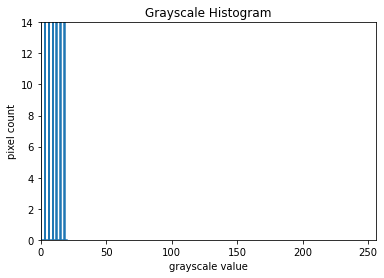

In [13]:
# histogram
histogram, bin_edges = np.histogram(sum_wm, bins=256, range=(0, 20))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 256.0])  # <- named arguments do not work here
plt.ylim([0.0, 14.0]) 
plt.plot(bin_edges[0:-1], histogram)  # <- or here

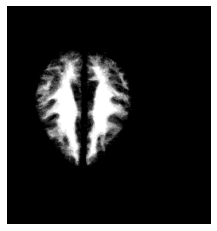

In [14]:
plt.figure()
plt.axis('off')
plt.imshow(probabilistic_atlas_wm[:,:,slice_no].T, cmap='gray')

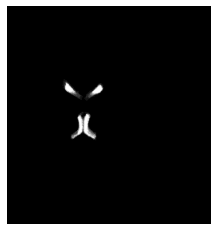

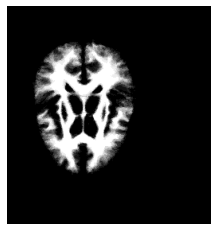

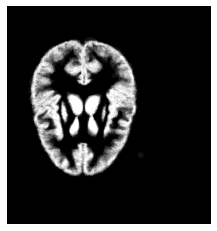

In [15]:
# Visualize the probabilistic atlas result per one slice per each class
slice_no = 120
slice_show(probabilistic_atlas_csf, slice_no)
slice_show(probabilistic_atlas_wm, slice_no)
slice_show(probabilistic_atlas_gm, slice_no)

In [16]:
# Saving the results for probabilistic atlas
probabilistic_atlas_csf_nifti = nib.Nifti1Image(probabilistic_atlas_csf, fixed_img_data.affine, fixed_img_data.header)
nib.save(probabilistic_atlas_csf_nifti, output_directory + '/probabilistic_atlas_csf.nii')
probabilistic_atlas_wm_nifti = nib.Nifti1Image(probabilistic_atlas_wm, fixed_img_data.affine, fixed_img_data.header)
nib.save(probabilistic_atlas_wm_nifti, output_directory + '/probabilistic_atlas_wm.nii')
probabilistic_atlas_gm_nifti = nib.Nifti1Image(probabilistic_atlas_gm, fixed_img_data.affine, fixed_img_data.header)
nib.save(probabilistic_atlas_gm_nifti, output_directory + '/probabilistic_atlas_gm.nii')